In [1]:
import sys
sys.path.append('/home/jjwhit/rcGAN/')

In [3]:
import torch
import yaml
import types
import json

import numpy as np
import matplotlib.patches as patches

from data.lightning.MassMappingDataModule import MMDataModule
from utils.parse_args import create_arg_parser
from pytorch_lightning import seed_everything
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import ndimage

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [73]:
%run /home/jjwhit/rcGAN/scripts/mass_map/plot.py --exp-name mmgan_training_8 --num-figs 5

[rank: 0] Global seed set to 1


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

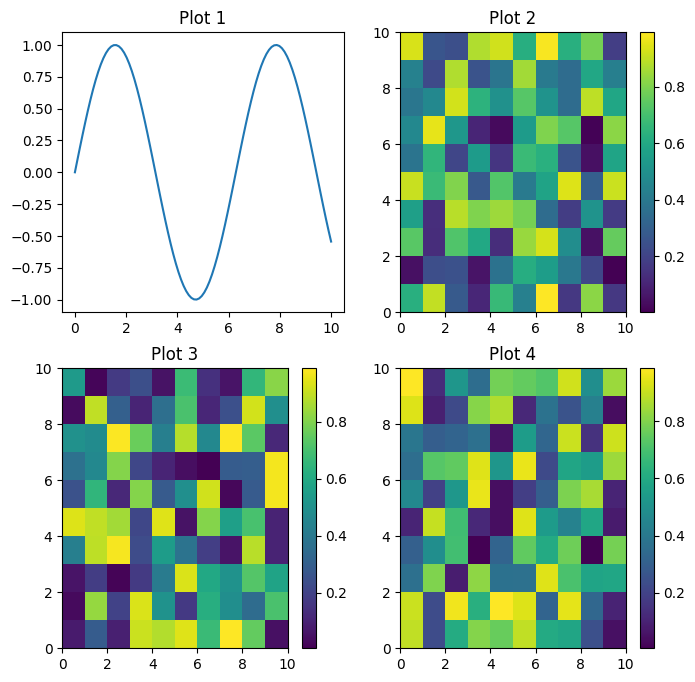

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data for plotting
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(2*x)
y4 = np.cos(2*x)

# Set up the figure and create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)

# Plot the first subplot (no colorbar)
axes[0, 0].plot(x, y1)
axes[0, 0].set_title('Plot 1')

# Plot the second subplot (with colorbar)
pcm = axes[0, 1].pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
axes[0, 1].set_title('Plot 2')
plt.colorbar(pcm, ax=axes[0, 1])

# Plot the third subplot (with colorbar)
pcm = axes[1, 0].pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
axes[1, 0].set_title('Plot 3')
plt.colorbar(pcm, ax=axes[1, 0])

# Plot the fourth subplot (with colorbar)
pcm = axes[1, 1].pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
axes[1, 1].set_title('Plot 4')
plt.colorbar(pcm, ax=axes[1, 1])


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

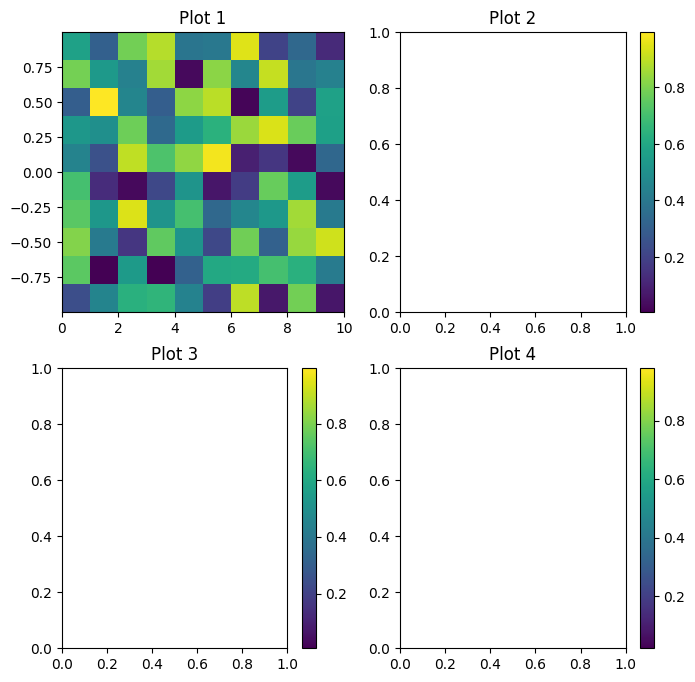

In [56]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Generate some example data for plotting
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(2*x)
y4 = np.cos(2*x)

# Set up the figure and the 2x2 grid layout with equal width and height ratios
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.2)

# Plot the first subplot (no colorbar) using imshow
im = np.random.rand(10, 10)  # Replace this with your actual data plot
ax1 = plt.subplot(gs[0, 0])
ax1.imshow(im, aspect='auto', extent=[x.min(), x.max(), y1.min(), y1.max()], origin='lower')
ax1.set_title('Plot 1')

# Plot the second subplot (with colorbar)
pcm = ax2.pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
ax2 = plt.subplot(gs[0, 1])
ax2.set_title('Plot 2')
plt.colorbar(pcm, ax=ax2)

# Plot the third subplot (with colorbar)
pcm = ax3.pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
ax3 = plt.subplot(gs[1, 0])
ax3.set_title('Plot 3')
plt.colorbar(pcm, ax=ax3)

# Plot the fourth subplot (with colorbar)
pcm = ax4.pcolormesh(np.random.rand(10, 10))  # Replace this with your actual data plot
ax4 = plt.subplot(gs[1, 1])
ax4.set_title('Plot 4')
plt.colorbar(pcm, ax=ax4)

# Make all subplots square by setting aspect ratio to 'equal'
ax[0,0].set_aspect('equal')

plt.show()
